<h1 align="center">DYNAMIC PRICING IMPLEMENTATION</h1> 

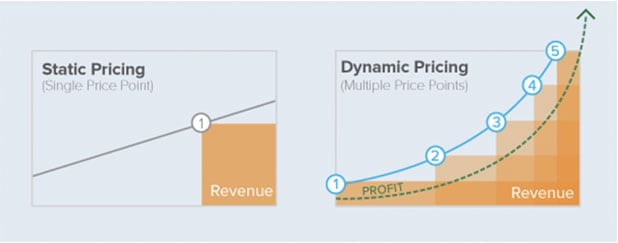

A game company gave gift coins to its users for item purchases in a game. Users buy various vehicles for their characters using these virtual coins.The game company did not specify a price for an item and allowed users to buy this item at the price they wanted.

The data set includes the fees paid to the items in 6 different categories.For example, for the item named "shield", users can buy this shield by paying the amounts they see fit.In other words, a user can pay with 30 units of the virtual money, and the other user with 45 units.Therefore, users can buy this item with the amounts they are willing to pay for themselves.

**Variables**

- *Category id*

- *Price*

In [41]:
#Importing required libraries

import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import statsmodels.stats.api as sms
from functools import reduce

In [42]:
#Pandas set option

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [43]:
#Read dataframe and copy

dataframe_ = pd.read_csv("pricing.csv", sep=";")
df = dataframe_.copy()

In [44]:
#Function for getting basic information

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Describe #####################")
    print(dataframe.describe().T)

In [45]:
check_df(df)

##################### Shape #####################
(3448, 2)
##################### Types #####################
category_id      int64
price          float64
dtype: object
##################### Head #####################
   category_id    price
0       489756 32.11775
1       361254 30.71137
2       361254 31.57261
3       489756 34.54384
4       489756 47.20582
##################### Tail #####################
      category_id    price
3443       489756 37.61742
3444       874521 33.67409
3445       489756 58.39922
3446       874521 65.72282
3447       489756 30.00000
##################### NA #####################
category_id    0
price          0
dtype: int64
##################### Describe #####################
                 count         mean          std          min          25%          50%          75%          max
category_id 3448.00000 542415.17198 192805.68991 201436.00000 457630.50000 489756.00000 675201.00000 874521.00000
price       3448.00000   3254.47577  25235.79901   

In [46]:
#Unique category id

df["category_id"].nunique()

6

In [47]:
#Category id value counts

df["category_id"].value_counts()

489756    1705
874521     750
361254     620
326584     145
675201     131
201436      97
Name: category_id, dtype: int64

In [49]:
#Price: minimum, mean, median, maximum and standard deviation information for category id

df.groupby("category_id").agg({"price":["min","mean","median","max","std"]})

price                                             
                 min       mean   median          max         std
category_id                                                      
201436      30.00000   36.17550 33.53468     74.45293     8.90015
326584      30.00000 1424.66518 31.74824 201436.63483 16725.44215
361254      30.00000 1659.68066 34.45919 201436.98459 18027.83367
489756      10.00000 3589.80853 35.63578 201436.98250 26485.60111
675201      30.00000 3112.24036 33.83557 201436.75501 24789.07311
874521      10.00000 4605.35726 34.40086 201436.99126 29995.51492

In [50]:
#Need more information price distribution

df["price"].quantile([0,0.01,0.10,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.95,0.96,0.97,0.98,0.99,1])

0.00000       10.00000
0.01000       30.00000
0.10000       30.00000
0.20000       31.01339
0.25000       31.89044
0.30000       32.63567
0.40000       33.92032
0.50000       34.79854
0.60000       35.24933
0.70000       37.76832
0.75000       41.53621
0.80000       45.46119
0.90000       62.50561
0.95000       92.97822
0.96000      108.54245
0.97000      135.22997
0.98000      206.61101
0.99000   201436.46420
1.00000   201436.99126
Name: price, dtype: float64

In [51]:
#Function for removing outliers

def remove_outliers(dataframe, variable, low=0.25, up=0.75):
    quartile1 = dataframe[variable].quantile(low)
    quartile3 = dataframe[variable].quantile(up)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_remove = dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)]
    print("Warning!!! There are {} deleted outliers".format(df_remove.shape[0]))
    return dataframe[~dataframe.index.isin(df_remove.index)]

In [52]:
#df2 --> deleted outliers dataframe

df2 = remove_outliers(df, "price")

Warning!!! There are 436 deleted outliers


In [53]:
#Checking basic information for df2

check_df(df2)

##################### Shape #####################
(3012, 2)
##################### Types #####################
category_id      int64
price          float64
dtype: object
##################### Head #####################
   category_id    price
0       489756 32.11775
1       361254 30.71137
2       361254 31.57261
3       489756 34.54384
4       489756 47.20582
##################### Tail #####################
      category_id    price
3441       874521 30.58824
3442       874521 34.92884
3443       489756 37.61742
3444       874521 33.67409
3447       489756 30.00000
##################### NA #####################
category_id    0
price          0
dtype: int64
##################### Describe #####################
                 count         mean          std          min          25%          50%          75%          max
category_id 3012.00000 538692.00365 194801.85777 201436.00000 361254.00000 489756.00000 675201.00000 874521.00000
price       3012.00000     35.48932      5.73596   

In [54]:
#A/B test for each double unique item 

def test_AB(dataframe, group, target, alpha):

    """
    The function gives A/B test results.
    The function compares between the groups by the desired alpha value according to the target variable.

    A/B Test Assumptions:
    1-Normality
    2-Homogeneity

    Steps:

    Step-1: Prepare the data for A/B testing

    Step-2: Define hypothesis

    H0: There is no difference between group averages
    H1: There is a difference between the group averages

    if p-value < alpha HO Reject (There is no statistically significant difference between the means),
    otherwise Fail to Reject H0 (There is a statistically significant difference between the means)

    Step-3: Check Normality
    H0: Distribution is normal
    H1: Distribution is not normal

    if p-value < alpha HO Reject (The assumption of normal distribution is not provided.),
    otherwise Fail to Reject H0 (The assumption of normal distribution is provided.)

    Step-4: Check Homogeneity
    H0: Variances are equal
    H1: variances are not equal

    if p-value < alpha HO Reject (The assumption of variance homogeneity is not provided.),
    otherwise Fail to Reject H0 (The assumption of variance homogeneity is provided.)

    Step-5: Decide which test to do

    if distribution is normal and variances are equal, apply independent t test
    if distribution is normal but variances are not equal, apply welch test (hint: independet t test, equal_var=False)
    if at least one of the pairs is not normally distributed, apply mann whitney-u test.

    Step-6: Combine the results

    Parameters
    ----------
    dataframe: dataframe
            Variable names are the data to be retrieved.

    group: str
            Variable name we want to group

    target: str
            Target variable. Values that we want to measure the difference

    alpha: float
            Threshold value that we measure p-values against.
            Alpha = 1-Confidence Level

    Returns
    -------
    dataframe
    (unique item set, test type, hypothesis result, p value, first item mean, second item mean, mean difference)

    Examples:
    test_AB(df, "category_id", "price", 0.05)

    """

    #Step-1

    temp_list = []
    for x in df[group].unique():
        for y in df[group].unique():
            temp_list.append([x, y])

    fset = set(frozenset(x) for x in temp_list)
    uniq_list = [list(x) for x in fset if len(x) > 1]

    final_df = pd.DataFrame()

    #Step-2

    #H0: There is no difference between group averages
    #H1: There is a difference between the group averages

    for i in range(0, len(uniq_list)):
        group_A = dataframe[dataframe[group] == uniq_list[i][0]][target]
        group_B = dataframe[dataframe[group] == uniq_list[i][1]][target]

    #Step-3

        normal_A = shapiro(group_A)[1] < alpha
        normal_B = shapiro(group_B)[1] < alpha

    #Step-4

        if (normal_A == False) & (normal_B == False):
            levene_ = levene(group_A, group_B)[1] < alpha
    #Step-5

            if levene_ == False:
                p_value = ttest_ind(group_A, group_B, equal_var=True)[1]
            else:
                p_value = ttest_ind(group_A, group_B, equal_var=False)[1]
        else:
            p_value = mannwhitneyu(group_A, group_B)[1]

    #Step-6

        temp_df = pd.DataFrame({"Hypothesis": [p_value < alpha],"p_value": p_value,
                             "Group_A_Mean": [group_A.mean()], "Group_B_Mean": [group_B.mean()],
                             "Mean_Difference":[abs(group_A.mean()-group_B.mean())]}, index = [set(uniq_list[i])])

        temp_df["Hypothesis"] = np.where(temp_df["Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
        temp_df["Test"] = np.where((normal_A == False) & (normal_B == False), "Parametric", "Non-Parametric")
        final_df = pd.concat([final_df, temp_df[["Test", "Hypothesis", "p_value","Group_A_Mean","Group_B_Mean","Mean_Difference"]]])
    return final_df

<h3 align="center">Dataframe With Outliers</h3> 

In [15]:
#A/B test for include outliers dataframe

tested_with_outliers = test_AB(df, "category_id", "price", 0.05)
tested_with_outliers.sort_values(by="Hypothesis")

,Test,Hypothesis,p_value,Group_A_Mean,Group_B_Mean,Mean_Difference
"{675201, 361254}",Non-Parametric,Fail to Reject H0,0.32506,3112.24036,1659.68066,1452.55970
"{874521, 675201}",Non-Parametric,Fail to Reject H0,0.27625,4605.35726,3112.24036,1493.11690
"{675201, 201436}",Non-Parametric,Fail to Reject H0,0.31852,3112.24036,36.17550,3076.06486
"{874521, 201436}",Non-Parametric,Fail to Reject H0,0.14784,4605.35726,36.17550,4569.18176
"{201436, 361254}",Non-Parametric,Fail to Reject H0,0.48664,36.17550,1659.68066,1623.50516
"{326584, 361254}",Non-Parametric,Reject H0,0.00000,1424.66518,1659.68066,235.01548
"{326584, 201436}",Non-Parametric,Reject H0,0.00051,1424.66518,36.17550,1388.48968
"{201436, 489756}",Non-Parametric,Reject H0,0.00000,36.17550,3589.80853,3553.63303
"{874521, 489756}",Non-Parametric,Reject H0,0.00000,4605.35726,3589.80853,1015.54873
"{326584, 489756}",Non-Parametric,Reject H0,0.00000,1424.66518,3589.80853,2165.14334


In [55]:
#Item sets that there is a difference between means (for df)

tested_with_outliers.reset_index(inplace=True)
tested_with_outliers.loc[tested_with_outliers["Hypothesis"] == "Reject H0", "index"]

0     {326584, 361254}
2     {326584, 201436}
3     {201436, 489756}
4     {874521, 489756}
5     {326584, 489756}
6     {326584, 675201}
7     {675201, 489756}
10    {326584, 874521}
12    {489756, 361254}
14    {874521, 361254}
Name: index, dtype: object

In [56]:
#Item sets that there is no difference between means (for df)

tested_with_outliers.loc[tested_with_outliers["Hypothesis"] == "Fail to Reject H0", "index"]

1     {675201, 361254}
8     {874521, 675201}
9     {675201, 201436}
11    {874521, 201436}
13    {201436, 361254}
Name: index, dtype: object

<h3 align="center">Dataframe Without Outliers</h3> 

In [18]:
#A/B test for dataframe without outliers 

tested_without_outliers = test_AB(df2, "category_id", "price", 0.05)
tested_without_outliers.sort_values(by="Hypothesis")

,Test,Hypothesis,p_value,Group_A_Mean,Group_B_Mean,Mean_Difference
"{675201, 361254}",Non-Parametric,Fail to Reject H0,0.40565,35.11418,34.17376,0.94042
"{874521, 675201}",Non-Parametric,Fail to Reject H0,0.45753,34.58983,35.11418,0.52436
"{675201, 201436}",Non-Parametric,Fail to Reject H0,0.44145,35.11418,34.39449,0.71970
"{874521, 201436}",Non-Parametric,Fail to Reject H0,0.48536,34.58983,34.39449,0.19534
"{201436, 361254}",Non-Parametric,Fail to Reject H0,0.43270,34.39449,34.17376,0.22073
"{874521, 361254}",Non-Parametric,Fail to Reject H0,0.32752,34.58983,34.17376,0.41606
"{326584, 361254}",Non-Parametric,Reject H0,0.00000,32.98714,34.17376,1.18663
"{326584, 201436}",Non-Parametric,Reject H0,0.00005,32.98714,34.39449,1.40735
"{201436, 489756}",Non-Parametric,Reject H0,0.00077,34.39449,36.79585,2.40136
"{874521, 489756}",Non-Parametric,Reject H0,0.00000,34.58983,36.79585,2.20602


In [19]:
#Item sets that there is a difference between means (for df2)

tested_without_outliers.reset_index(inplace=True)
tested_without_outliers.loc[tested_without_outliers["Hypothesis"] == "Reject H0", "index"]

0     {326584, 361254}
2     {326584, 201436}
3     {201436, 489756}
4     {874521, 489756}
5     {326584, 489756}
6     {326584, 675201}
7     {675201, 489756}
10    {326584, 874521}
12    {489756, 361254}
Name: index, dtype: object

In [57]:
#Item sets that there is no difference between means (for df2)

tested_without_outliers.loc[tested_without_outliers["Hypothesis"] == "Fail to Reject H0", "index"]

1     {675201, 361254}
8     {874521, 675201}
9     {675201, 201436}
11    {874521, 201436}
13    {201436, 361254}
14    {874521, 361254}
Name: index, dtype: object

**The test results with and without outliers gave very similar result but I will use non-outlier dataframe to avoid misleading results**

In [21]:
#tested_without_outliers  *** Fail to Reject H0 so there is no difference between means ***
#     {675201, 361254}
#     {874521, 675201}
#     {675201, 201436}
#     {874521, 201436}
#     {201436, 361254}
#     {874521, 361254}

# Unique category id

similar = [201436,361254,675201,874521]

In [58]:
#tested_without_outliers *** Reject H0 so there is a difference between means **
#     {326584, 361254}
#     {326584, 201436}
#     {201436, 489756}
#     {874521, 489756}
#     {326584, 489756}
#     {326584, 675201}
#     {675201, 489756}
#     {326584, 874521}
#     {489756, 361254}

#Unique category id except similar ids

not_similar = [326584,489756]

In [59]:
#All unique category id
all_list = [201436,361254,675201,874521,326584,489756]

In [60]:
#Item price determination function
#for constant price: if similar use mean of groups mean, if not similar use mean of groups median
#for flexible price: if similar, not similar and all use low and high value for 95% confidence, mean of groups mean, mean of groups median
#all price for just observing

def item_price(dataframe,type="all",con_price=True):
    sum = 0
    price = []
    if con_price:
        if type == "similar":
            for i in similar:
                sum += dataframe.loc[dataframe["category_id"] == i, "price"].mean()
            price = sum/len(similar)
            return price
        elif type == "not_similar":
            for i in not_similar:
                sum += dataframe.loc[dataframe["category_id"] == i, "price"].median()
            price = sum/len(not_similar)
            return price
        elif type == "all":
            for i in similar:
                sum += dataframe.loc[dataframe["category_id"] == i, "price"].mean()
            for j in not_similar:
                sum += dataframe.loc[dataframe["category_id"] == j, "price"].median()
            price = sum/len(all_list)
            return np.mean(price)
    else:
        if type == "similar":
            for i in similar:
                for j in dataframe.loc[dataframe["category_id"] == i, "price"]:
                    price.append(j)
            range = sms.DescrStatsW(price).tconfint_mean()
            mean = np.mean(price)
            median = np.median(price)
            print(f"Price mean range with 95% confidence between {'%.4f' % range[0]} and {'%.4f' % range[1]} \nMean: {'%.4f' % mean} \nMedian: {'%.4f' % median}")

        elif type == "not_similar":
            for i in not_similar:
                for j in dataframe.loc[dataframe["category_id"] == i, "price"]:
                    price.append(j)
            range = sms.DescrStatsW(price).tconfint_mean()
            mean = np.mean(price)
            median = np.median(price)
            print(f"Price mean range with 95% confidence between {'%.4f' % range[0]} and {'%.4f' % range[1]} \nMean: {'%.4f' % mean} \nMedian: {'%.4f' % median}")

        elif type == "all":
            for i in all_list:
                for j in dataframe.loc[dataframe["category_id"] == i, "price"]:
                    price.append(j)
            range = sms.DescrStatsW(price).tconfint_mean()
            mean = np.mean(price)
            median = np.median(price)
            print(f"Price mean range with 95% confidence between {'%.4f' % range[0]} and {'%.4f' % range[1]} \nMean: {'%.4f' % mean} \nMedian: {'%.4f' % median}")

        return [range, mean, median]

In [61]:
#constant price for all unique category id

all_con = [item_price(df2,type="all",con_price=True)]
all_con

[34.07031675454481]

In [62]:
#constant price for all unique similar category id

similar_con = [item_price(df2,type="similar",con_price=True)]
similar_con

[34.56806450964221]

In [63]:
#constant price for all unique not similar category id

not_similar_con = [item_price(df2,type="not_similar",con_price=True)]
not_similar_con

[33.07482124435]

In [64]:
#flexible price for all unique category id

all_flex =item_price(df2,type="all",con_price=False)
all_flex

Price mean range with 95% confidence between 35.2844 and 35.6942 
Mean: 35.4893 
Median: 34.3746


[(35.2843928251852, 35.69424852825349), 35.489320676719345, 34.3746272319]

In [65]:
#flexible price for all unique similar category id

similar_flex = item_price(df2,type="similar",con_price=False)
similar_flex

Price mean range with 95% confidence between 34.2142 and 34.6879 
Mean: 34.4510 
Median: 33.9971


[(34.21418057578277, 34.6878859740201), 34.451033274901434, 33.9971315093]

In [66]:
#flexible price for all unique not similar category id

not_similar_flex = item_price(df2,type="not_similar",con_price=False)
not_similar_flex

Price mean range with 95% confidence between 36.1426 and 36.7869 
Mean: 36.4648 
Median: 34.6856


[(36.142643449221254, 36.78688176674456), 36.464762607982905, 34.6856245818]

In [67]:
#The function for capturing part from within categories

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [33]:
#The function for price simulation
# For constant price: to find income use constant price
# For flexible price: to find income use low confidence value, high confidence value, mean and median

def price_simulation(dataframe,data, method):
    if "con" in str(namestr(data,globals())):
        if method == "all":
            freq = len(dataframe[dataframe["price"] >= data[0]])
            income = freq * data[0]
            return income
    else:
        if method == "low_conf":
            freq = len(dataframe[dataframe["price"] >= data[0][0]])
            income = freq * data[0][0]
            return income

        if method == "high_conf":
            freq = len(dataframe[dataframe["price"] >= data[0][1]])
            income = freq * data[0][1]
            return income

        if method == "mean":
            freq = len(dataframe[dataframe["price"] >= data[1]])
            income = freq * data[1]
            return income

        if method == "median":
            freq = len(dataframe[dataframe["price"] >= data[2]])
            income = freq * data[2]
            return income

In [68]:
#There are 15 scenario: 3 for constant price, 12 for flexible price
#Use functions and convert to dataframe. Finally merge dataframes


all_con_price = pd.DataFrame(["all_data","constant","all",price_simulation(df2, all_con, "all")],index=["data","constant_flexible","method","Income"]).T
similar_con_price = pd.DataFrame(["similar_group","constant","all",price_simulation(df2, similar_con, "all")],index=["data","constant_flexible","method","Income"]).T
not_similar_con_price = pd.DataFrame(["not_similar_group","constant","all",price_simulation(df2, not_similar_con, "all")],index=["data","constant_flexible","method","Income"]).T

all_flex_low_conf = pd.DataFrame(["all_data","flexible","low_conf",price_simulation(df2, all_flex, "low_conf")],index=["data","constant_flexible","method","Income"]).T
all_flex_high_conf = pd.DataFrame(["all_data","flexible","high_conf",price_simulation(df2, all_flex, "high_conf")],index=["data","constant_flexible","method","Income"]).T
all_flex_mean = pd.DataFrame(["all_data","flexible","mean",price_simulation(df2, all_flex, "mean")],index=["data","constant_flexible","method","Income"]).T
all_flex_median= pd.DataFrame(["all_data","flexible","median",price_simulation(df2, all_flex, "median")],index=["data","constant_flexible","method","Income"]).T

similar_flex_low_conf = pd.DataFrame(["similar_group","flexible","low_conf",price_simulation(df2, similar_flex, "low_conf")] ,index=["data","constant_flexible","method","Income"]).T
similar_flex_high_conf = pd.DataFrame(["similar_group","flexible","high_conf",price_simulation(df2, similar_flex, "high_conf")] ,index=["data","constant_flexible","method","Income"]).T
similar_flex_mean = pd.DataFrame(["similar_group","flexible","mean",price_simulation(df2, similar_flex, "mean")] ,index=["data","constant_flexible","method","Income"]).T
similar_flex_median = pd.DataFrame(["similar_group","flexible","median",price_simulation(df2, similar_flex, "median")] ,index=["data","constant_flexible","method","Income"]).T

not_similar_flex_low_conf = pd.DataFrame(["not_similar_group","flexible","low_conf",price_simulation(df2, not_similar_flex, "low_conf")],index=["data","constant_flexible","method","Income"]).T
not_similar_flex_high_conf = pd.DataFrame(["not_similar_group","flexible","high_conf",price_simulation(df2, not_similar_flex, "high_conf")],index=["data","constant_flexible","method","Income"]).T
not_similar_flex_mean = pd.DataFrame(["not_similar_group","flexible","mean",price_simulation(df2, not_similar_flex, "mean")],index=["data","constant_flexible","method","Income"]).T
not_similar_flex_median= pd.DataFrame(["not_similar_group","flexible","median",price_simulation(df2, not_similar_flex, "median")],index=["data","constant_flexible","method","Income"]).T

merging = [all_con_price,similar_con_price,not_similar_con_price,all_flex_low_conf,all_flex_high_conf,all_flex_mean,all_flex_median,similar_flex_low_conf,similar_flex_high_conf,similar_flex_mean,similar_flex_median,not_similar_flex_low_conf,not_similar_flex_high_conf,not_similar_flex_mean,not_similar_flex_median]


df_merged = reduce(lambda  left,right: pd.merge(left,right, how='outer'), merging)
df_merged.sort_values(by="Income", ascending=False)

,data,constant_flexible,method,Income
2,not_similar_group,constant,all,61221.49412
10,similar_group,flexible,median,55109.35018
0,all_data,constant,all,54376.22554
7,similar_group,flexible,low_conf,53203.05080
6,all_data,flexible,median,51768.18861
9,similar_group,flexible,mean,50918.62718
1,similar_group,constant,all,49190.35580
14,not_similar_group,flexible,median,47623.36255
8,similar_group,flexible,high_conf,47591.77956
3,all_data,flexible,low_conf,33308.46683


In [35]:
#Not similar group expected income table
#Fixed price should be used for non similar groups

df_merged[(df_merged["data"]=="not_similar_group") ].sort_values(by="Income", ascending=False)

,data,constant_flexible,method,Income
2,not_similar_group,constant,all,61221.49412
14,not_similar_group,flexible,median,47623.36255
11,not_similar_group,flexible,low_conf,27612.97960
13,not_similar_group,flexible,mean,26509.88242
12,not_similar_group,flexible,high_conf,25382.94842


In [36]:
#Similar group expected income table
#The median method provides the highest income for similar group but the low confidence method is more secure and provides the 2nd highest income.

df_merged[(df_merged["data"]=="similar_group")].sort_values(by="Income", ascending=False)

,data,constant_flexible,method,Income
10,similar_group,flexible,median,55109.35018
7,similar_group,flexible,low_conf,53203.05080
9,similar_group,flexible,mean,50918.62718
1,similar_group,constant,all,49190.35580
8,similar_group,flexible,high_conf,47591.77956


In [69]:
#Just for observing

df_merged[(df_merged["data"]=="all_data") ].sort_values(by="Income", ascending=False)

,data,constant_flexible,method,Income
0,all_data,constant,all,54376.22554
6,all_data,flexible,median,51768.18861
3,all_data,flexible,low_conf,33308.46683
5,all_data,flexible,mean,31550.00608
4,all_data,flexible,high_conf,30411.49975


<h2 align="center">Conclusion</h2> 

### Best Scenario (but risky)

*If we use constant price method for non similar groups and flexieble median price method for similar groups, expected max income:*

In [70]:
df_merged[(df_merged["data"]=="not_similar_group")]["Income"].max() + df_merged[(df_merged["data"]=="similar_group")]["Income"].max()

116330.84429986714

*Real income:*

In [71]:
df2["price"].sum()

106893.83387827866

In [95]:
expected_max_income = df_merged[(df_merged["data"]=="not_similar_group")]["Income"].max() + df_merged[(df_merged["data"]=="similar_group")]["Income"].max()
real_income = df2["price"].sum()
profit= expected_max_income-real_income
profitperc = ((expected_max_income-real_income)/real_income)
print(f"If we use constant price method for non similar group and flexieble median price method for similar group\nexpected profit will be {'%.3f' %profit} unit\nexpected profit percentage {'%.3f' %(profitperc*100)} % ")

If we use constant price method for non similar group and flexieble median price method for similar group
expected profit will be 9437.010 unit
expected profit percentage 8.828 % 


### 2nd Best Scenario (Secure)

*If we use constant price method for non similar groups and flexieble low confidence price method for similar groups, expected income:*

In [92]:
df_merged[(df_merged["data"]=="not_similar_group")]["Income"].max() + df_merged[(df_merged["data"]=="similar_group") & (df_merged["method"]=="low_conf")]["Income"].values[0]

114424.54491863406

In [94]:
expected_max_income = df_merged[(df_merged["data"]=="not_similar_group")]["Income"].max() + df_merged[(df_merged["data"]=="similar_group") & (df_merged["method"]=="low_conf")]["Income"].values[0]
real_income = df2["price"].sum()
profit= expected_max_income-real_income
profitperc = ((expected_max_income-real_income)/real_income)
print(f"If we use constant price method for non similar groups and flexieble median price method for similar groups\nexpected profit will be {'%.3f' %profit} unit\nexpected profit percentage {'%.3f' %(profitperc*100)} % ")

If we use constant price method for non similar groups and flexieble median price method for similar groups
expected profit will be 7530.711 unit
expected profit percentage 7.045 % 
